In [1]:
#Type 1 MEL SPECTROGRAM

Training model for spectrogram type: mel
Epoch 1/50
53/53 [==============================] - 91s 1s/step - loss: 0.6638 - accuracy: 0.6262 - val_loss: 0.6607 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 58s 1s/step - loss: 0.6609 - accuracy: 0.6262 - val_loss: 0.6600 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 59s 1s/step - loss: 0.6609 - accuracy: 0.6262 - val_loss: 0.6599 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 64s 1s/step - loss: 0.6606 - accuracy: 0.6262 - val_loss: 0.6591 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 58s 1s/step - loss: 0.6603 - accuracy: 0.6262 - val_loss: 0.6588 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 61s 1s/step - loss: 0.6603 - accuracy: 0.6262 - val_loss: 0.6584 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 58s 1s/step - loss: 0.6604 - accuracy: 0.6262 - val_loss: 0.6582 - 

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


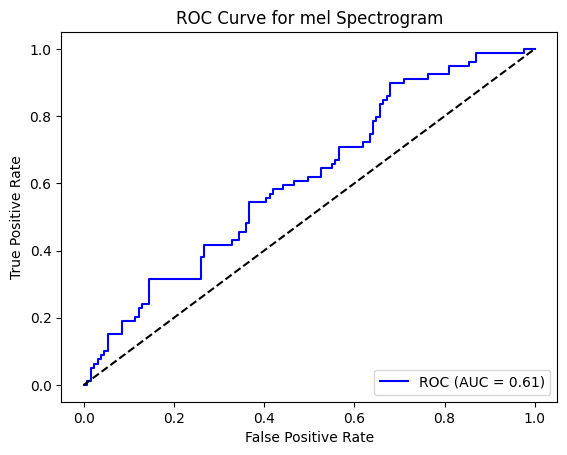


Performance Metrics for Spectrogram mel:
Accuracy: 62.38%
F1 Score: 0.48
Precision: 0.39
Recall: 0.62
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.61
Training Time: 2884.20 seconds
Testing Time: 17.95 seconds


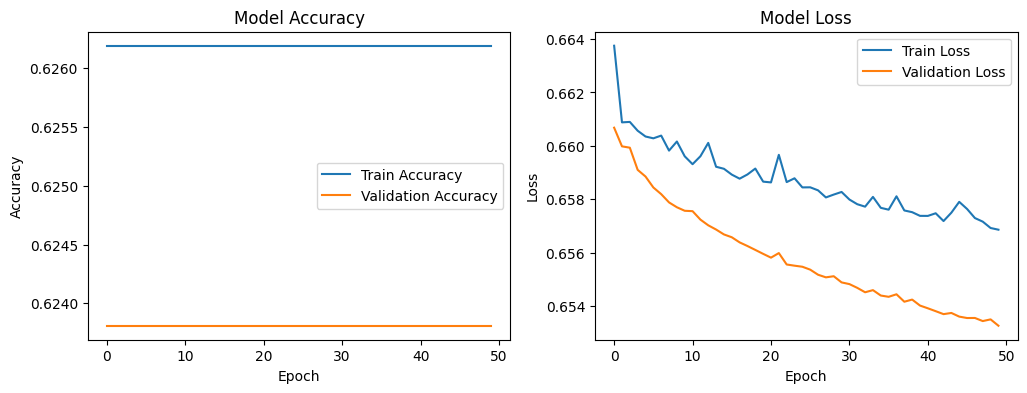

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mel
Epoch 1/50
53/53 [==============================] - 163s 3s/step - loss: 0.6679 - accuracy: 0.6262 - val_loss: 0.6568 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 142s 3s/step - loss: 0.6558 - accuracy: 0.6262 - val_loss: 0.6533 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 132s 2s/step - loss: 0.6513 - accuracy: 0.6262 - val_loss: 0.6495 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 92s 2s/step - loss: 0.6467 - accuracy: 0.6262 - val_loss: 0.6457 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 90s 2s/step - loss: 0.6413 - accuracy: 0.6262 - val_loss: 0.6424 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 134s 3s/step - loss: 0.6364 - accuracy: 0.6262 - val_loss: 0.6385 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 144s 3s/step - loss: 0.6326 - accuracy: 0.6262 - val_loss: 0.63

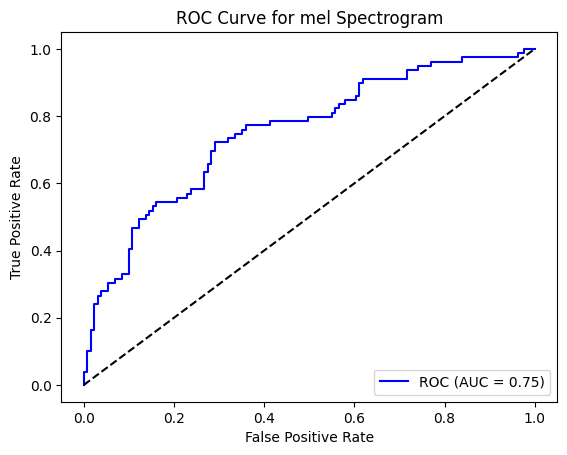

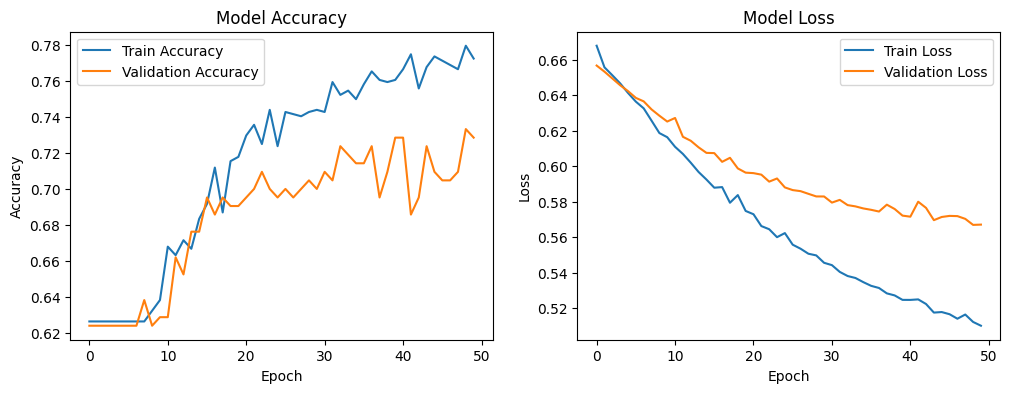

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mel
Epoch 1/50
53/53 [==============================] - 19s 260ms/step - loss: 0.6483 - accuracy: 0.6190 - val_loss: 0.6196 - val_accuracy: 0.6762
Epoch 2/50
53/53 [==============================] - 12s 220ms/step - loss: 0.5772 - accuracy: 0.7262 - val_loss: 0.5943 - val_accuracy: 0.7143
Epoch 3/50
53/53 [==============================] - 11s 211ms/step - loss: 0.5433 - accuracy: 0.7583 - val_loss: 0.5826 - val_accuracy: 0.7000
Epoch 4/50
53/53 [==============================] - 12s 226ms/step - loss: 0.5215 - accuracy: 0.7679 - val_loss: 0.5710 - val_accuracy: 0.7143
Epoch 5/50
53/53 [==============================] - 12s 221ms/step - loss: 0.5014 - accuracy: 0.7857 - val_loss: 0.5652 - val_accuracy: 0.7238
Epoch 6/50
53/53 [==============================] - 11s 216ms/step - loss: 0.4860 - accuracy: 0.8024 - val_loss: 0.5607 - val_accuracy: 0.7238
Epoch 7/50
53/53 [==============================] - 12s 218ms/step - loss: 0.4673 - accuracy: 0.7976 

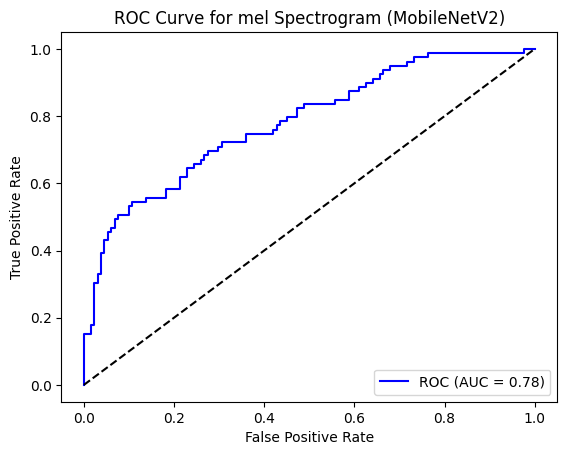

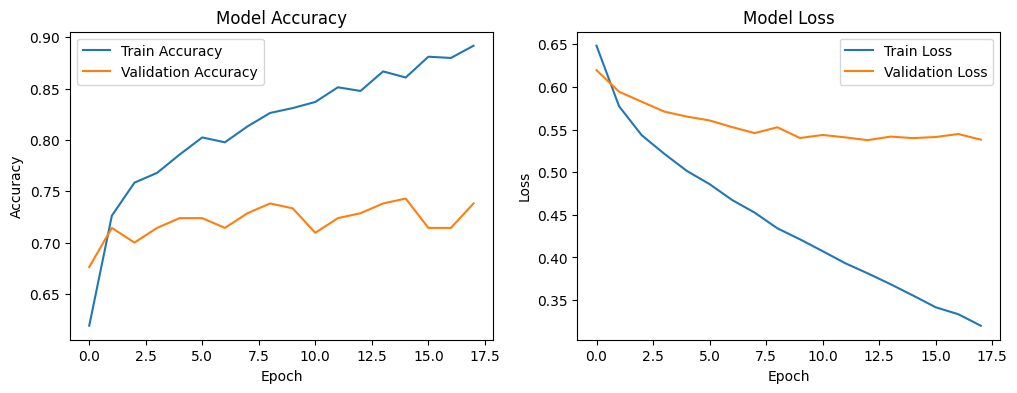


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa   ROC AUC  \
0  72.857143  0.724881    0.72398  0.728571     0.816794  0.408304  0.781332   

   Training Time (s)  Testing Time (s)  
0         212.174625          3.969964  


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mel']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

#Type 2 MFCC

Training model for spectrogram type: mfcc
Epoch 1/50
53/53 [==============================] - 47s 763ms/step - loss: 0.6625 - accuracy: 0.6262 - val_loss: 0.6624 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 26s 492ms/step - loss: 0.6618 - accuracy: 0.6262 - val_loss: 0.6621 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 26s 485ms/step - loss: 0.6618 - accuracy: 0.6262 - val_loss: 0.6623 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 24s 454ms/step - loss: 0.6621 - accuracy: 0.6262 - val_loss: 0.6621 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 28s 521ms/step - loss: 0.6624 - accuracy: 0.6262 - val_loss: 0.6622 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 26s 489ms/step - loss: 0.6613 - accuracy: 0.6262 - val_loss: 0.6621 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 24s 449ms/step - loss: 0.6614 - accuracy: 0.6262

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


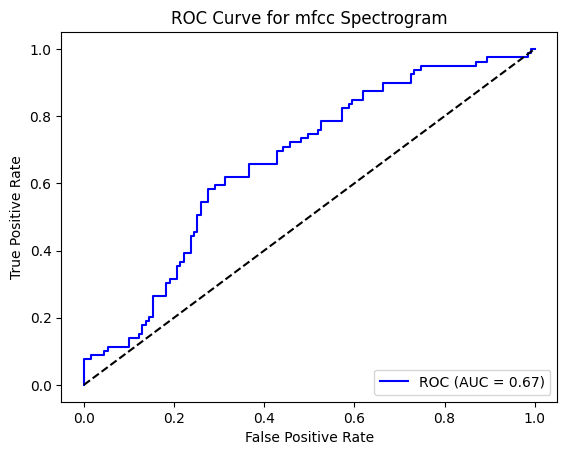


Performance Metrics for Spectrogram mfcc:
Accuracy: 62.38%
F1 Score: 0.48
Precision: 0.39
Recall: 0.62
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.67
Training Time: 1216.69 seconds
Testing Time: 4.43 seconds


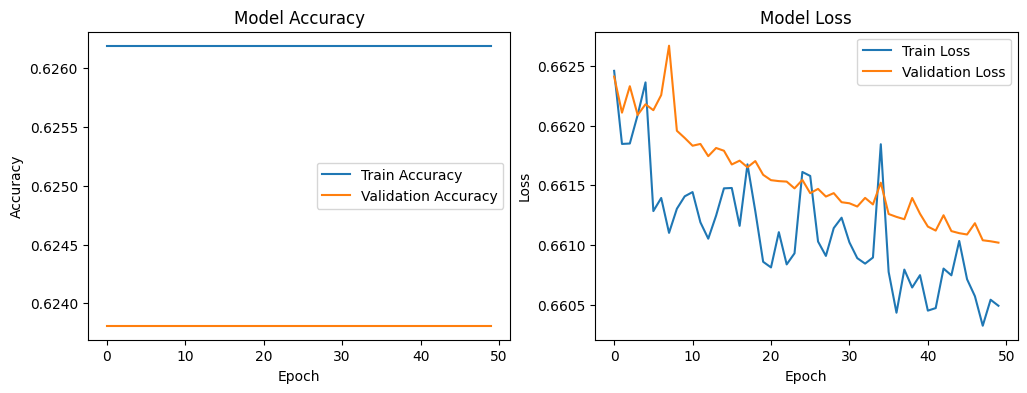

In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mfcc
Epoch 1/50
53/53 [==============================] - 54s 1s/step - loss: 0.6942 - accuracy: 0.5464 - val_loss: 0.6634 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 60s 1s/step - loss: 0.6621 - accuracy: 0.6262 - val_loss: 0.6620 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 58s 1s/step - loss: 0.6597 - accuracy: 0.6262 - val_loss: 0.6610 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 57s 1s/step - loss: 0.6587 - accuracy: 0.6262 - val_loss: 0.6609 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 62s 1s/step - loss: 0.6569 - accuracy: 0.6262 - val_loss: 0.6595 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 67s 1s/step - loss: 0.6560 - accuracy: 0.6262 - val_loss: 0.6592 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 64s 1s/step - loss: 0.6539 - accuracy: 0.6262 - val_loss: 0.6582 -

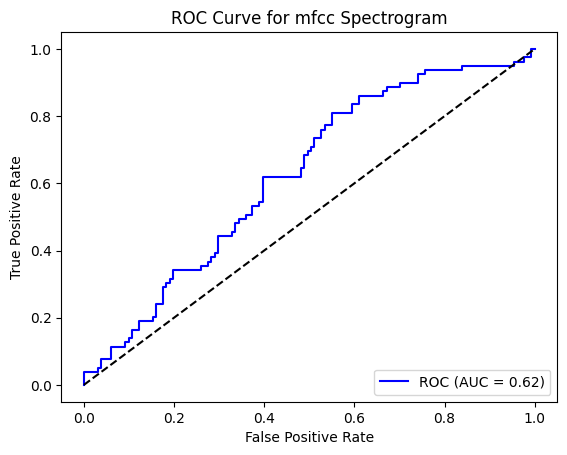

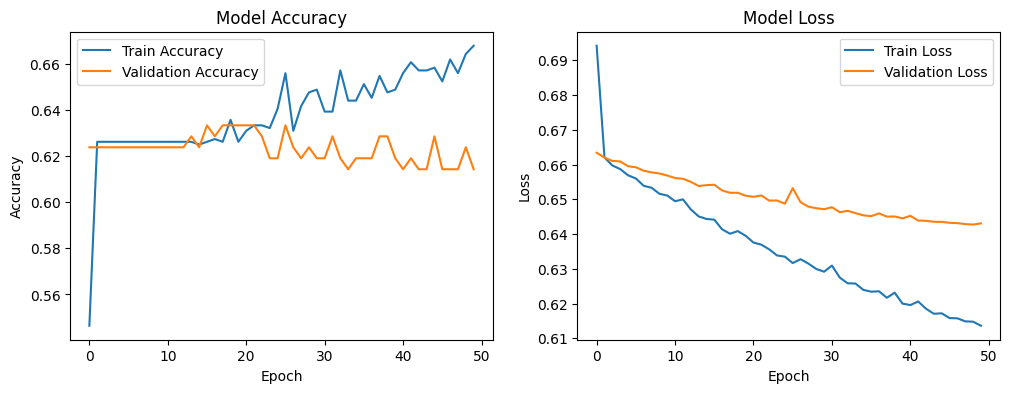

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: mfcc
Epoch 1/50
53/53 [==============================] - 10s 152ms/step - loss: 0.6702 - accuracy: 0.6202 - val_loss: 0.6558 - val_accuracy: 0.6286
Epoch 2/50
53/53 [==============================] - 7s 128ms/step - loss: 0.6312 - accuracy: 0.6440 - val_loss: 0.6409 - val_accuracy: 0.6762
Epoch 3/50
53/53 [==============================] - 6s 122ms/step - loss: 0.6072 - accuracy: 0.6726 - val_loss: 0.6224 - val_accuracy: 0.6810
Epoch 4/50
53/53 [==============================] - 7s 141ms/step - loss: 0.5874 - accuracy: 0.6976 - val_loss: 0.6126 - val_accuracy: 0.6857
Epoch 5/50
53/53 [==============================] - 8s 146ms/step - loss: 0.5709 - accuracy: 0.7071 - val_loss: 0.6055 - val_accuracy: 0.6952
Epoch 6/50
53/53 [==============================] - 7s 131ms/step - loss: 0.5531 - accuracy: 0.7357 - val_loss: 0.6006 - val_accuracy: 0.7286
Epoch 7/50
53/53 [==============================] - 7s 123ms/step - loss: 0.5466 - accuracy: 0.7310 - val

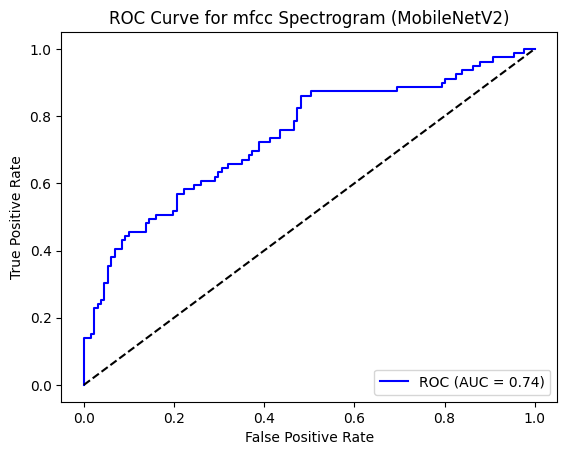

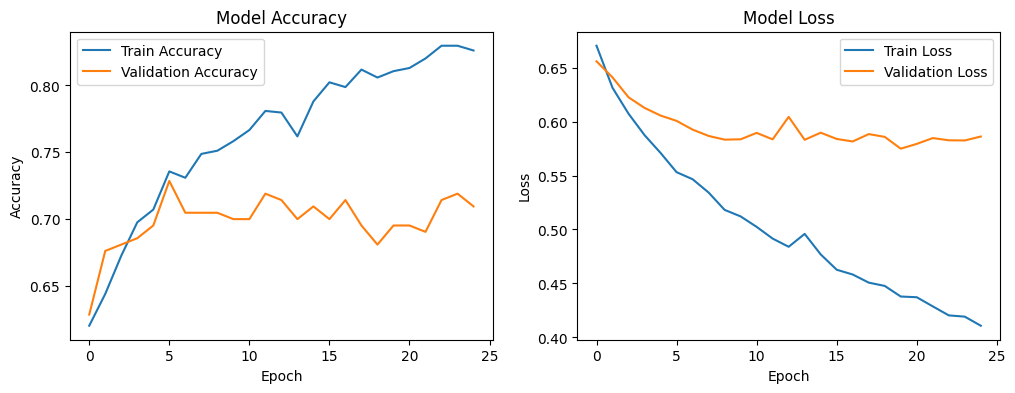


Complete Metrics Table:
   Accuracy  F1 Score  Precision    Recall  Specificity    Kappa   ROC AUC  \
0  69.52381  0.688153   0.687528  0.695238      0.80916  0.32699  0.737173   

   Training Time (s)  Testing Time (s)  
0          181.23992           1.69504  


In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['mfcc']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

In [ ]:
#Type 3 STFT

Training model for spectrogram type: stft
Epoch 1/50
53/53 [==============================] - 27s 457ms/step - loss: 0.6711 - accuracy: 0.6262 - val_loss: 0.6631 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 25s 465ms/step - loss: 0.6629 - accuracy: 0.6262 - val_loss: 0.6623 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 24s 454ms/step - loss: 0.6614 - accuracy: 0.6262 - val_loss: 0.6617 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 23s 444ms/step - loss: 0.6610 - accuracy: 0.6262 - val_loss: 0.6614 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 23s 443ms/step - loss: 0.6610 - accuracy: 0.6262 - val_loss: 0.6614 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 24s 455ms/step - loss: 0.6609 - accuracy: 0.6262 - val_loss: 0.6612 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 25s 470ms/step - loss: 0.6609 - accuracy: 0.6262

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


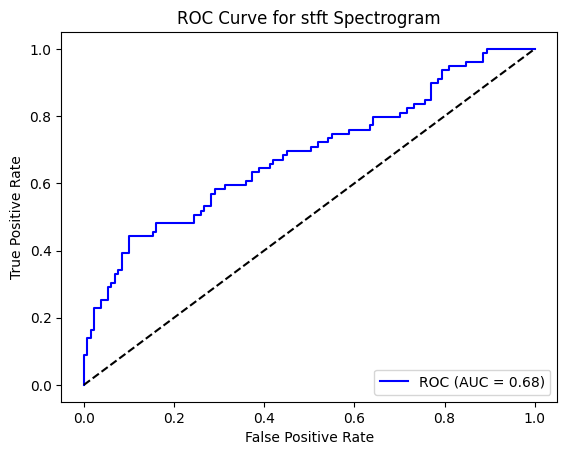


Performance Metrics for Spectrogram stft:
Accuracy: 62.38%
F1 Score: 0.48
Precision: 0.39
Recall: 0.62
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.68
Training Time: 1206.55 seconds
Testing Time: 4.68 seconds


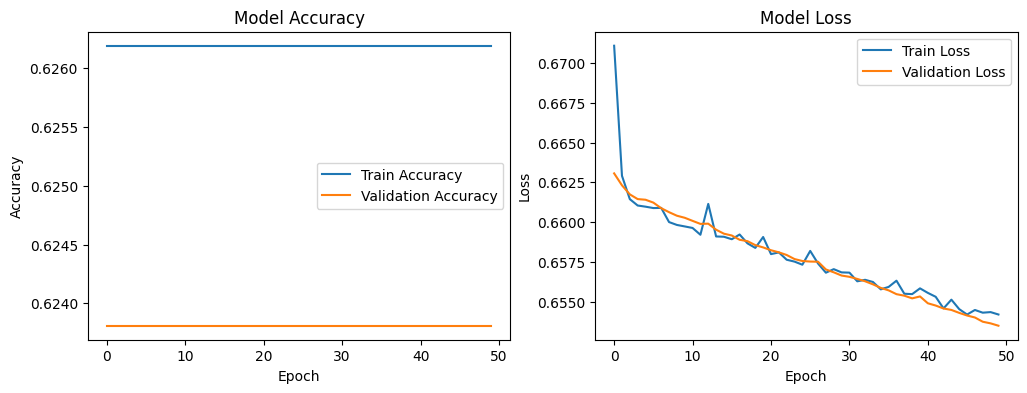

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: stft
Epoch 1/50
53/53 [==============================] - 61s 1s/step - loss: 0.6660 - accuracy: 0.6226 - val_loss: 0.6561 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 61s 1s/step - loss: 0.6580 - accuracy: 0.6262 - val_loss: 0.6540 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 60s 1s/step - loss: 0.6548 - accuracy: 0.6262 - val_loss: 0.6507 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 60s 1s/step - loss: 0.6516 - accuracy: 0.6262 - val_loss: 0.6486 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 60s 1s/step - loss: 0.6492 - accuracy: 0.6262 - val_loss: 0.6472 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 60s 1s/step - loss: 0.6474 - accuracy: 0.6298 - val_loss: 0.6476 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 67s 1s/step - loss: 0.6440 - accuracy: 0.6262 - val_loss: 0.6446 -

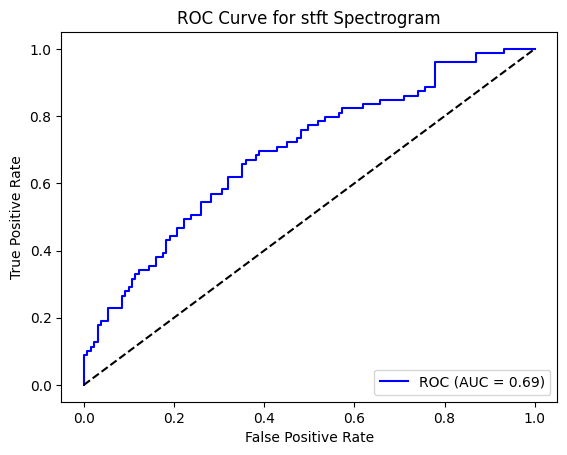

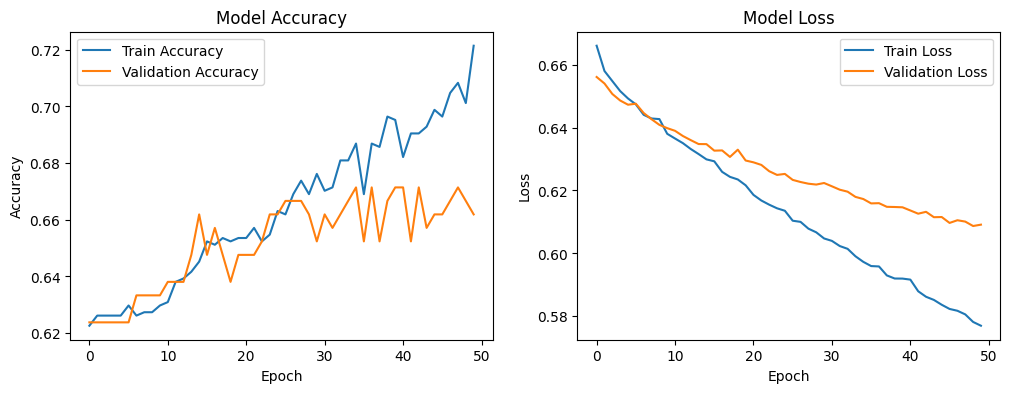

In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: stft
Epoch 1/50
53/53 [==============================] - 10s 146ms/step - loss: 0.6657 - accuracy: 0.6238 - val_loss: 0.6437 - val_accuracy: 0.6429
Epoch 2/50
53/53 [==============================] - 6s 115ms/step - loss: 0.6112 - accuracy: 0.6798 - val_loss: 0.6195 - val_accuracy: 0.6667
Epoch 3/50
53/53 [==============================] - 7s 127ms/step - loss: 0.5757 - accuracy: 0.7119 - val_loss: 0.6004 - val_accuracy: 0.6952
Epoch 4/50
53/53 [==============================] - 7s 141ms/step - loss: 0.5435 - accuracy: 0.7536 - val_loss: 0.5858 - val_accuracy: 0.6952
Epoch 5/50
53/53 [==============================] - 7s 137ms/step - loss: 0.5178 - accuracy: 0.7583 - val_loss: 0.5750 - val_accuracy: 0.7000
Epoch 6/50
53/53 [==============================] - 6s 121ms/step - loss: 0.4951 - accuracy: 0.7857 - val_loss: 0.5681 - val_accuracy: 0.7048
Epoch 7/50
53/53 [==============================] - 8s 142ms/step - loss: 0.4763 - accuracy: 0.7952 - val

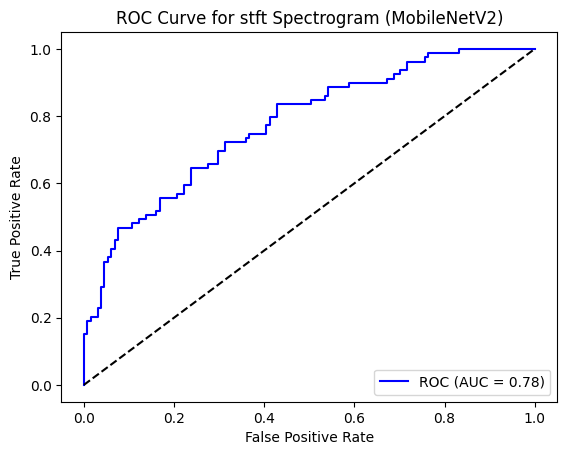

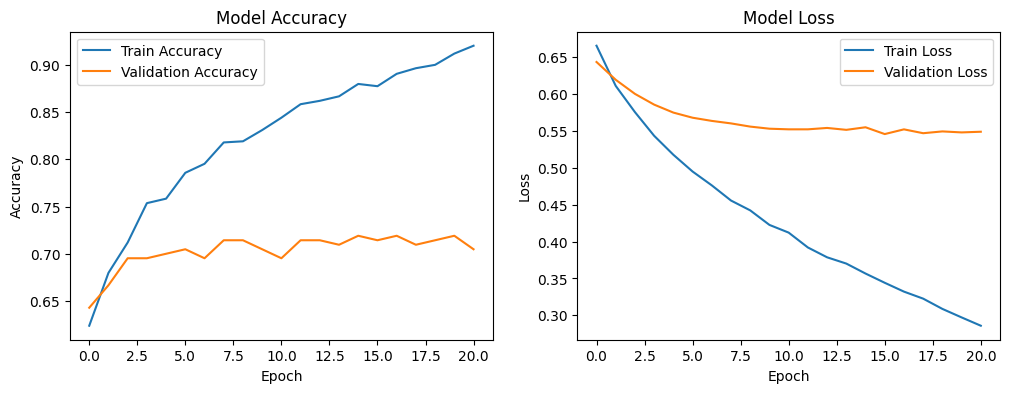


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa  ROC AUC  \
0  71.428571  0.709885   0.708853  0.714286      0.80916  0.375558  0.77563   

   Training Time (s)  Testing Time (s)  
0         149.049901          1.672335  


In [9]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['stft']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

In [10]:
#Type 4 CQT

Training model for spectrogram type: cqt
Epoch 1/50
53/53 [==============================] - 38s 658ms/step - loss: 0.6640 - accuracy: 0.6262 - val_loss: 0.6624 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 42s 791ms/step - loss: 0.6625 - accuracy: 0.6262 - val_loss: 0.6620 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 43s 806ms/step - loss: 0.6617 - accuracy: 0.6262 - val_loss: 0.6619 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 39s 730ms/step - loss: 0.6610 - accuracy: 0.6262 - val_loss: 0.6610 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 35s 670ms/step - loss: 0.6627 - accuracy: 0.6262 - val_loss: 0.6608 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 32s 609ms/step - loss: 0.6601 - accuracy: 0.6262 - val_loss: 0.6604 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 34s 653ms/step - loss: 0.6595 - accuracy: 0.6262 

C:\Users\NUTAN SINGH\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


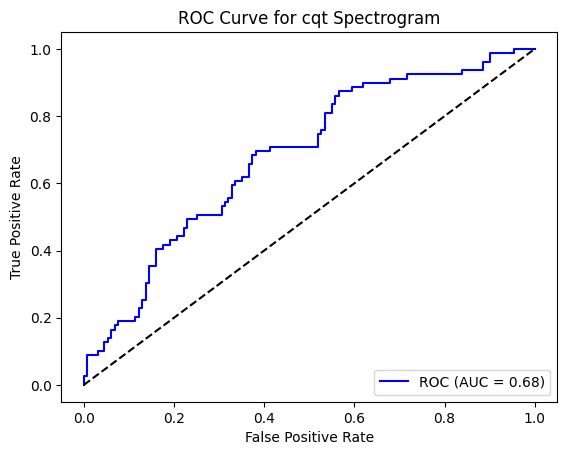


Performance Metrics for Spectrogram cqt:
Accuracy: 62.38%
F1 Score: 0.48
Precision: 0.39
Recall: 0.62
Specificity: 1.00
Kappa: 0.00
ROC AUC: 0.68
Training Time: 1709.55 seconds
Testing Time: 5.70 seconds


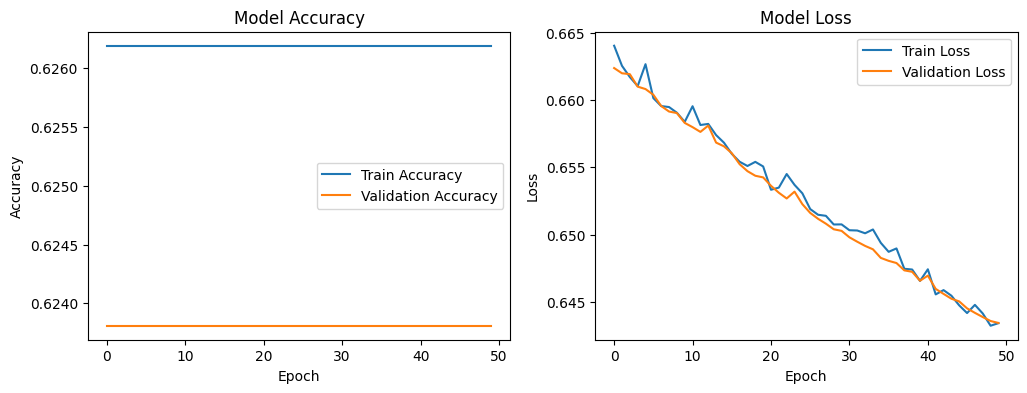

In [11]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: cqt
Epoch 1/50
53/53 [==============================] - 78s 1s/step - loss: 0.6710 - accuracy: 0.6024 - val_loss: 0.6564 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 72s 1s/step - loss: 0.6577 - accuracy: 0.6262 - val_loss: 0.6551 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 72s 1s/step - loss: 0.6526 - accuracy: 0.6262 - val_loss: 0.6511 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 74s 1s/step - loss: 0.6500 - accuracy: 0.6262 - val_loss: 0.6478 - val_accuracy: 0.6286
Epoch 5/50
53/53 [==============================] - 72s 1s/step - loss: 0.6454 - accuracy: 0.6250 - val_loss: 0.6444 - val_accuracy: 0.6286
Epoch 6/50
53/53 [==============================] - 72s 1s/step - loss: 0.6424 - accuracy: 0.6286 - val_loss: 0.6425 - val_accuracy: 0.6333
Epoch 7/50
53/53 [==============================] - 73s 1s/step - loss: 0.6408 - accuracy: 0.6369 - val_loss: 0.6381 - 

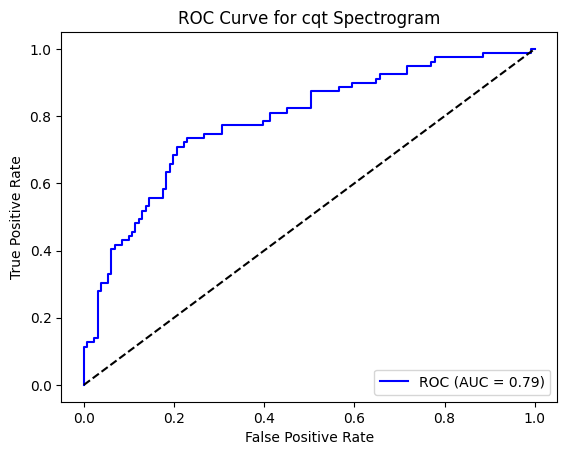

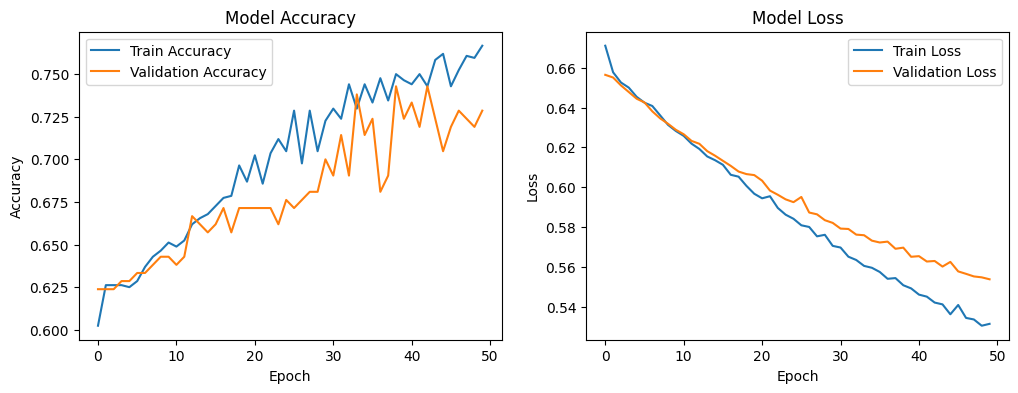

In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: cqt
Epoch 1/50
53/53 [==============================] - 10s 160ms/step - loss: 0.6377 - accuracy: 0.6512 - val_loss: 0.6202 - val_accuracy: 0.7095
Epoch 2/50
53/53 [==============================] - 8s 157ms/step - loss: 0.5696 - accuracy: 0.7298 - val_loss: 0.5882 - val_accuracy: 0.7238
Epoch 3/50
53/53 [==============================] - 7s 133ms/step - loss: 0.5213 - accuracy: 0.7607 - val_loss: 0.5616 - val_accuracy: 0.7381
Epoch 4/50
53/53 [==============================] - 8s 154ms/step - loss: 0.4905 - accuracy: 0.7893 - val_loss: 0.5450 - val_accuracy: 0.7381
Epoch 5/50
53/53 [==============================] - 8s 159ms/step - loss: 0.4557 - accuracy: 0.8083 - val_loss: 0.5347 - val_accuracy: 0.7286
Epoch 6/50
53/53 [==============================] - 7s 132ms/step - loss: 0.4350 - accuracy: 0.8321 - val_loss: 0.5297 - val_accuracy: 0.7333
Epoch 7/50
53/53 [==============================] - 7s 140ms/step - loss: 0.4090 - accuracy: 0.8417 - val_

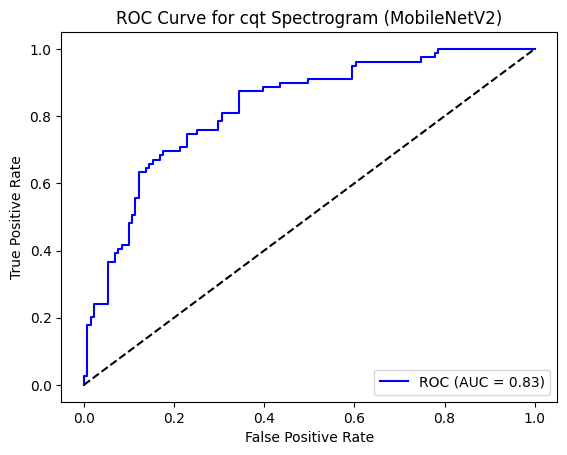

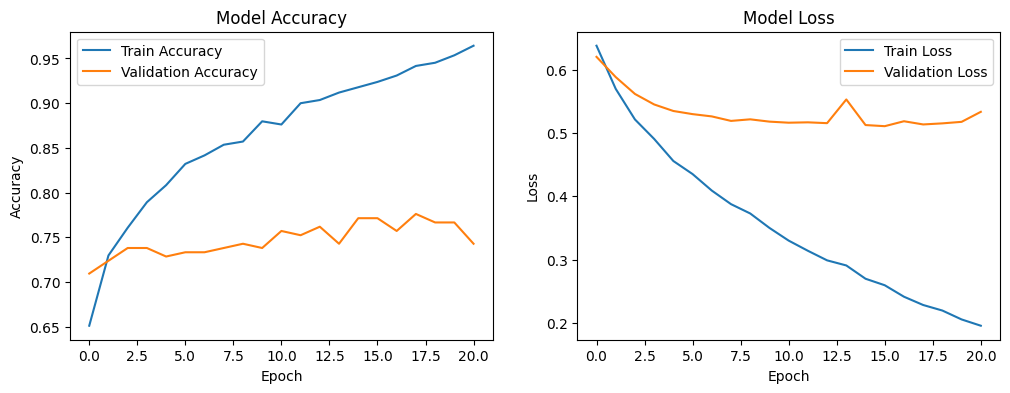


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity   Kappa   ROC AUC  \
0  77.142857  0.765129   0.768664  0.771429     0.877863  0.4926  0.825201   

   Training Time (s)  Testing Time (s)  
0          167.56363          1.746632  


In [13]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['cqt']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)

In [14]:
#Type 5 chroma

Training model for spectrogram type: chroma
Epoch 1/50
53/53 [==============================] - 36s 626ms/step - loss: 0.7035 - accuracy: 0.5464 - val_loss: 0.6614 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 36s 675ms/step - loss: 0.6595 - accuracy: 0.6262 - val_loss: 0.6567 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 34s 647ms/step - loss: 0.6581 - accuracy: 0.6262 - val_loss: 0.6546 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 34s 654ms/step - loss: 0.6567 - accuracy: 0.6262 - val_loss: 0.6529 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 35s 670ms/step - loss: 0.6560 - accuracy: 0.6262 - val_loss: 0.6512 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 34s 646ms/step - loss: 0.6551 - accuracy: 0.6262 - val_loss: 0.6499 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 36s 673ms/step - loss: 0.6538 - accuracy: 0.62

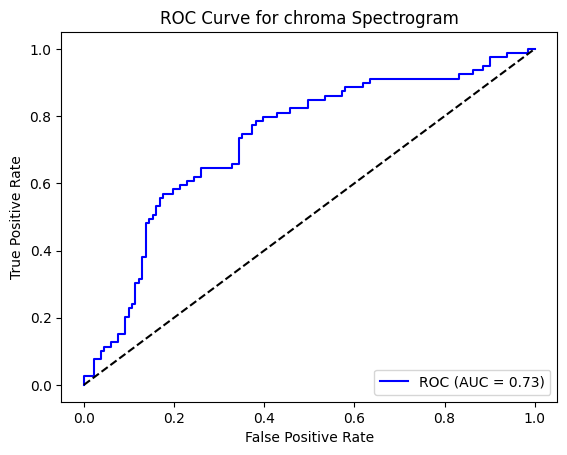


Performance Metrics for Spectrogram chroma:
Accuracy: 63.81%
F1 Score: 0.55
Precision: 0.63
Recall: 0.64
Specificity: 0.95
Kappa: 0.08
ROC AUC: 0.73
Training Time: 3386.84 seconds
Testing Time: 12.71 seconds


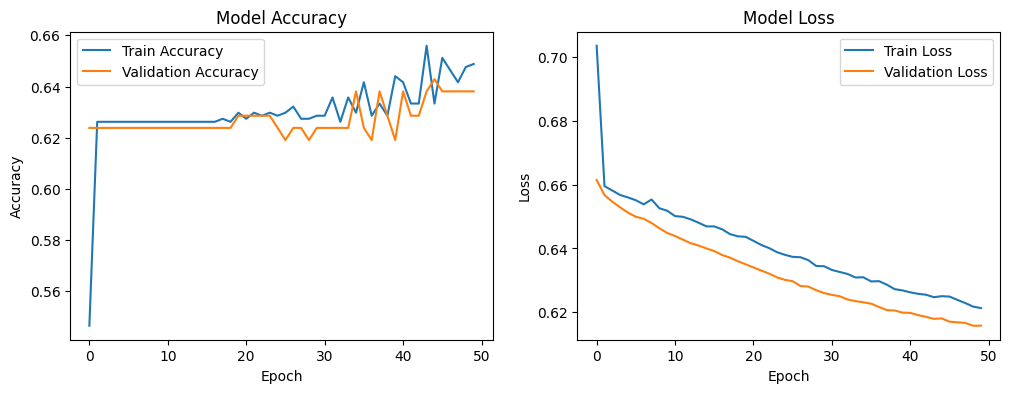

In [15]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the ResNet50 model function
def build_resnet50_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    
    # Shuffle and split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(img_data, labels, test_size=0.2, stratify=labels, random_state=42)
    
    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_resnet50_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=50, 
                        batch_size=16, 
                        verbose=1, 
                        callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Display metrics
    print(f"\nPerformance Metrics for Spectrogram {spectrogram}:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: chroma
Epoch 1/50
53/53 [==============================] - 137s 3s/step - loss: 0.6657 - accuracy: 0.6262 - val_loss: 0.6663 - val_accuracy: 0.6238
Epoch 2/50
53/53 [==============================] - 147s 3s/step - loss: 0.6604 - accuracy: 0.6262 - val_loss: 0.6609 - val_accuracy: 0.6238
Epoch 3/50
53/53 [==============================] - 142s 3s/step - loss: 0.6574 - accuracy: 0.6262 - val_loss: 0.6588 - val_accuracy: 0.6238
Epoch 4/50
53/53 [==============================] - 77s 1s/step - loss: 0.6540 - accuracy: 0.6262 - val_loss: 0.6543 - val_accuracy: 0.6238
Epoch 5/50
53/53 [==============================] - 70s 1s/step - loss: 0.6493 - accuracy: 0.6262 - val_loss: 0.6511 - val_accuracy: 0.6238
Epoch 6/50
53/53 [==============================] - 68s 1s/step - loss: 0.6471 - accuracy: 0.6262 - val_loss: 0.6480 - val_accuracy: 0.6238
Epoch 7/50
53/53 [==============================] - 67s 1s/step - loss: 0.6447 - accuracy: 0.6262 - val_loss: 0.6

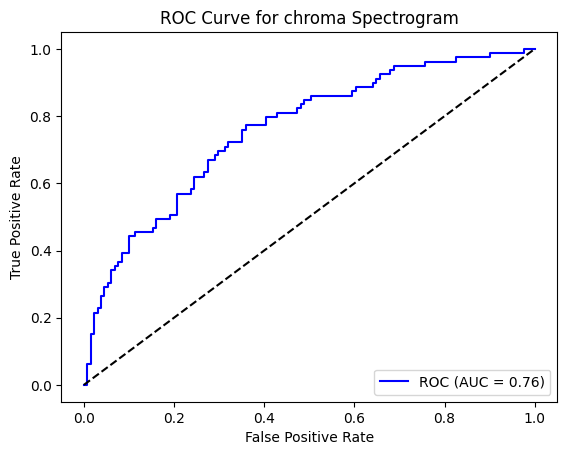

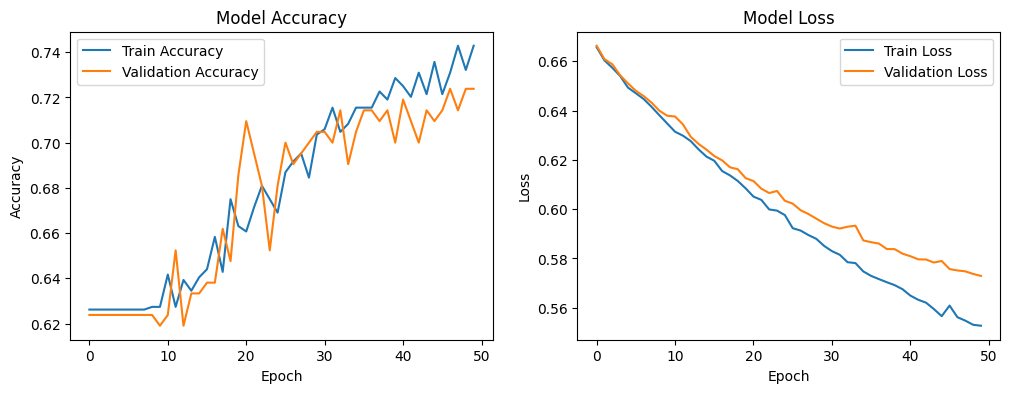

In [16]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the VGG19 model function
def build_vgg19_model(input_shape, num_classes):
    base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_vgg19_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary (similar to your fold_metrics structure)
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve (single curve instead of mean±std from k-fold)
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

Training model for spectrogram type: chroma
Epoch 1/50
53/53 [==============================] - 11s 168ms/step - loss: 0.6807 - accuracy: 0.5940 - val_loss: 0.6434 - val_accuracy: 0.6667
Epoch 2/50
53/53 [==============================] - 7s 129ms/step - loss: 0.6225 - accuracy: 0.6571 - val_loss: 0.6156 - val_accuracy: 0.7238
Epoch 3/50
53/53 [==============================] - 7s 125ms/step - loss: 0.5977 - accuracy: 0.7071 - val_loss: 0.6029 - val_accuracy: 0.7333
Epoch 4/50
53/53 [==============================] - 9s 171ms/step - loss: 0.5679 - accuracy: 0.7298 - val_loss: 0.5643 - val_accuracy: 0.7476
Epoch 5/50
53/53 [==============================] - 10s 184ms/step - loss: 0.5449 - accuracy: 0.7476 - val_loss: 0.5593 - val_accuracy: 0.7667
Epoch 6/50
53/53 [==============================] - 7s 142ms/step - loss: 0.5303 - accuracy: 0.7631 - val_loss: 0.5400 - val_accuracy: 0.7476
Epoch 7/50
53/53 [==============================] - 8s 147ms/step - loss: 0.5171 - accuracy: 0.7738 - 

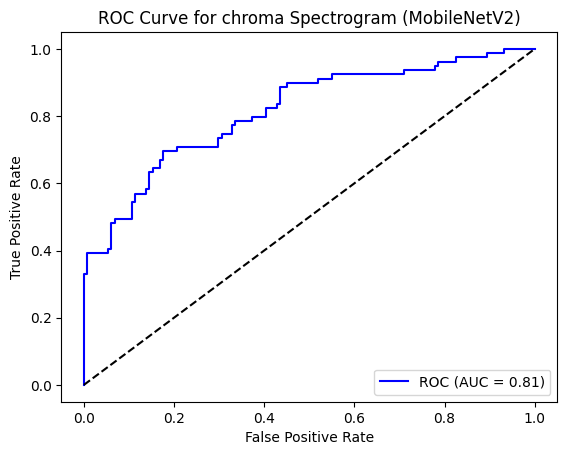

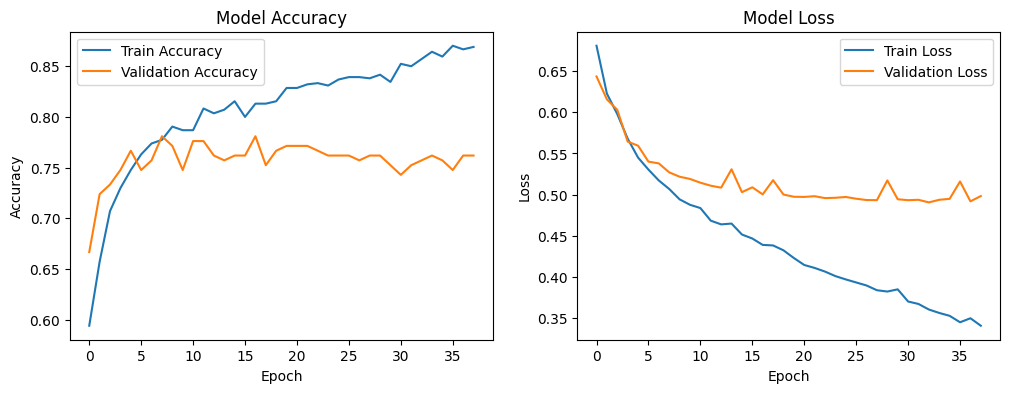


Complete Metrics Table:
    Accuracy  F1 Score  Precision    Recall  Specificity     Kappa   ROC AUC  \
0  75.714286  0.749901   0.753543  0.757143     0.870229  0.459473  0.814765   

   Training Time (s)  Testing Time (s)  
0         296.613716          2.651102  


In [17]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_score, recall_score, cohen_kappa_score
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time

# Define the base path for all data folders
data_dir = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\Cleaned_ReadTextCONVERTED'
spectrogram_folders = ['chroma']

# Function to load images and labels from a directory
def load_data_from_directory(base_path, label):
    img_data_list = []
    labels = []
    for img_file in os.listdir(base_path):
        img_path = os.path.join(base_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            img_data_list.append(img)
            labels.append(label)
    return img_data_list, labels

# Define the MobileNetV2 model function
def build_mobilenetv2_model(input_shape, num_classes):
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Process each spectrogram folder separately
for spectrogram in spectrogram_folders:
    print(f"Training model for spectrogram type: {spectrogram}")

    control_path = os.path.join(data_dir, spectrogram, 'HC')
    pathological_path = os.path.join(data_dir, spectrogram, 'PD')

    control_images, control_labels = load_data_from_directory(control_path, 0)
    pathological_images, pathological_labels = load_data_from_directory(pathological_path, 1)

    img_data_list = control_images + pathological_images
    labels = control_labels + pathological_labels

    img_data = np.array(img_data_list).astype('float32') / 255.0
    labels = np.array(labels)
    x, y = shuffle(img_data, labels, random_state=42)

    # Split data into 80% train and 20% test
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

    num_classes = 2
    input_shape = (128, 128, 3)
    model = build_mobilenetv2_model(input_shape, num_classes)

    # Convert labels to categorical
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    model.compile(optimizer=Adam(learning_rate=0.0001, decay=0.0006), loss='binary_crossentropy', metrics=['accuracy'])
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Record training time
    start_train = time.time()
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1, callbacks=[early_stop])
    training_time = time.time() - start_train

    # Record testing time
    start_test = time.time()
    y_pred_prob = model.predict(X_test)
    testing_time = time.time() - start_test

    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = np.mean(y_pred == y_true) * 100
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)

    # Specificity calculation
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    # ROC AUC calculation
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)

    # Create metrics dictionary
    metrics_dict = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "Kappa": kappa,
        "ROC AUC": roc_auc,
        "Training Time (s)": training_time,
        "Testing Time (s)": testing_time
    }

    print(f"\nPerformance Metrics for {spectrogram} Spectrogram:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Kappa: {kappa:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Testing Time: {testing_time:.2f} seconds")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {spectrogram} Spectrogram (MobileNetV2)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Save metrics to DataFrame for potential further analysis
    metrics_df = pd.DataFrame([metrics_dict])
    print("\nComplete Metrics Table:")
    print(metrics_df)